# Google Colab 한글 폰트 설치

In [1]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


- 테스트

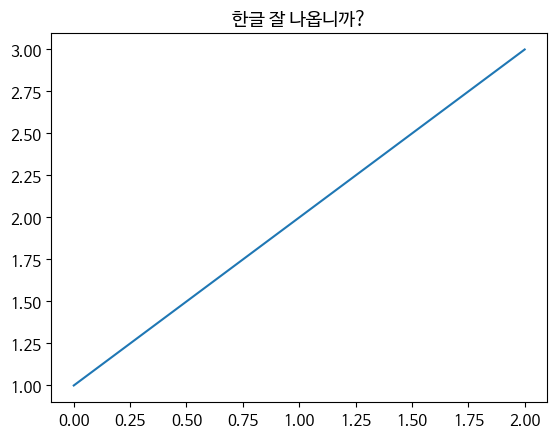

In [3]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Colab과 드라이브 연동

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 라이브러리 불러오기

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 시계열 시각화 맛보기

## matplotlib 설정

In [6]:
plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

In [7]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/'

df = pd.read_csv(DATA_PATH + 'widget_sales.csv')

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


## 주어진 시계열 데이터 시각화

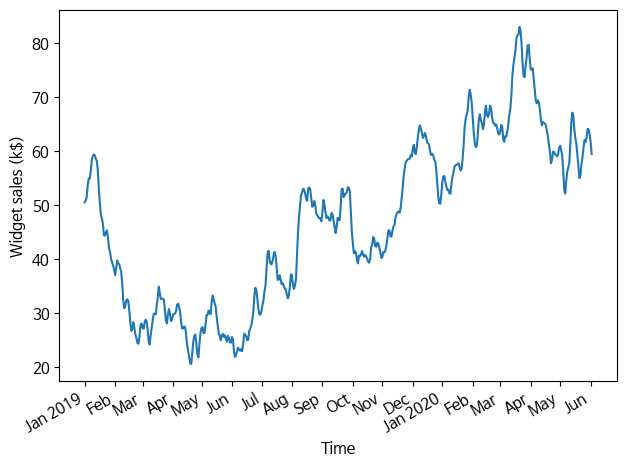

In [8]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 정상성 확인
- 귀무가설 채택 (정상성 시계열이 아님)

In [9]:
ADF_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


## 차분 후, 시각화

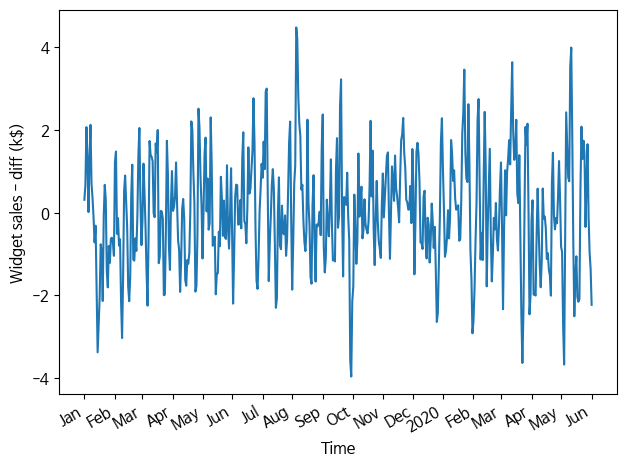

In [10]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)

fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 차분 데이터 정상성 확인
- 귀무가설 기각 ==> 대립가설 채택

In [11]:
ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


## 자기상관관계 그래프
- ACF 도식화 결과 지연 2까지는 유의한 계수가 있음 확인
- 2차 이동평균 모델 또는 MA(2) 모델 사용하여 정상적 시계열 예측

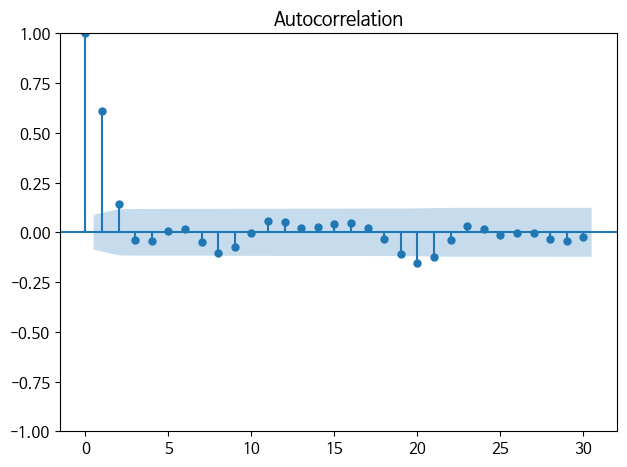

In [12]:
plot_acf(widget_sales_diff, lags=30);

plt.tight_layout()
plt.show()

# 이동평균 예측
- MA(2) 모델 개발

## 데이터 분리

In [13]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


## 데이터 시각화

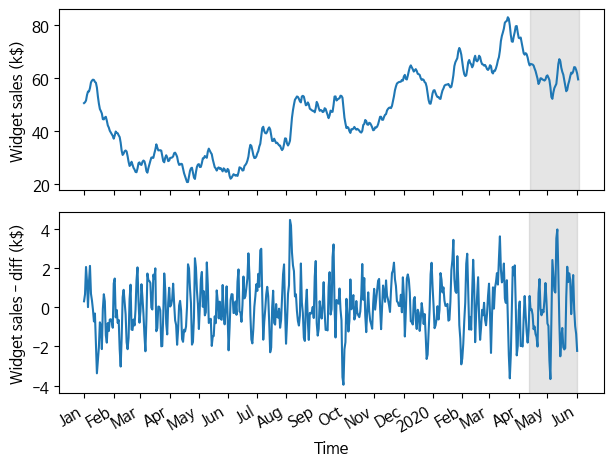

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 롤링 예측 함수 구현
- train_len : 데이터 요소의 개수 초기화
- horizon : 테스트 집합의 길이와 같으며, 예측할 값의 개수
- window : 한 번에 예측할 시간 단계 횟수 지정
- method : 사용할 모델 지정

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA

In [16]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


## 훈련 데이터 도식화
- 훈련 집합과 테스트 집합 간의 변화 확인

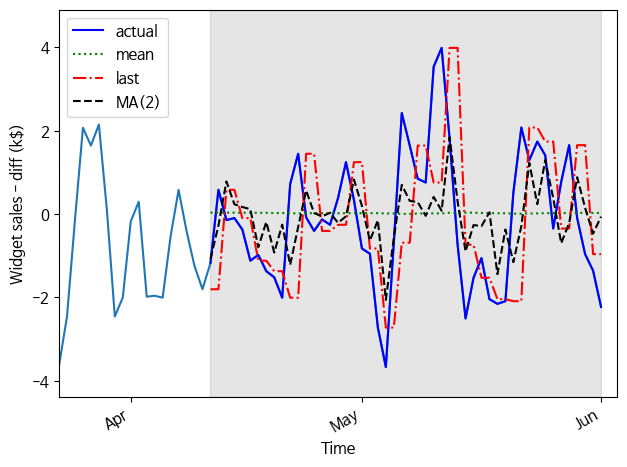

In [17]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498],
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.948171449776926


## 모형 평가

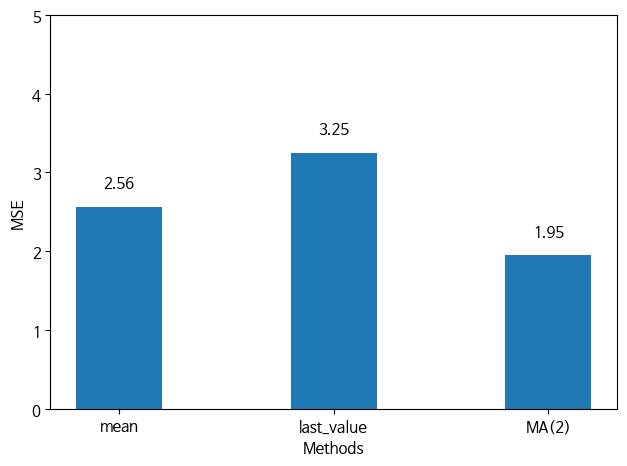

In [19]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.show()

## 예측결과 역변환
- 정상적 수열에 대한 모델 확보
- 예측결과를 역변환하여 데이터 집합의 변환하지 않은 원래 규모로 되돌려야 함

In [20]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

## 역변환한 MA(2) 결과 시각화
- 가장 큰 최저점과 가장 낮은 최고점은 예측하지 못함

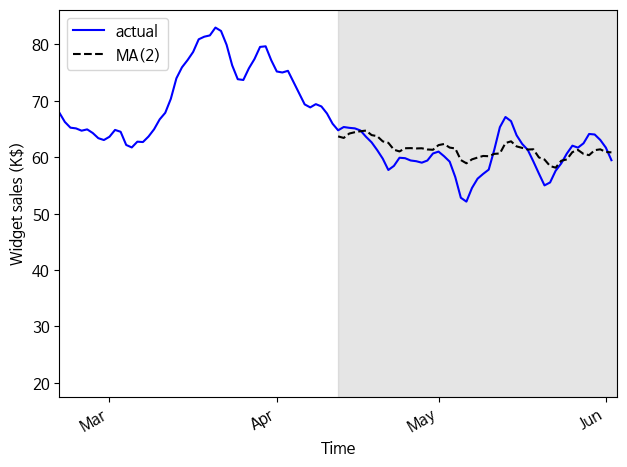

In [21]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498],
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

2.3244709244596082


# 자기회귀과정

## 라이브러리 불러오기

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## 데이터 시각화
- 소매점의 주간 평균 유동인구 예측

In [24]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/'

df = pd.read_csv(DATA_PATH + 'foot_traffic.csv')

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


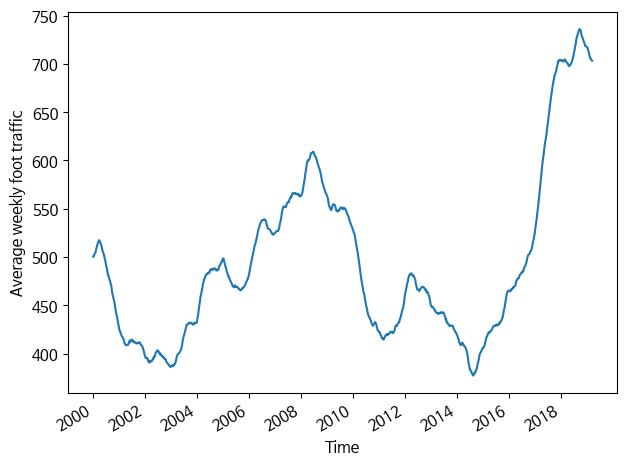

In [25]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 차분 및 정상성 확인

In [26]:
ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


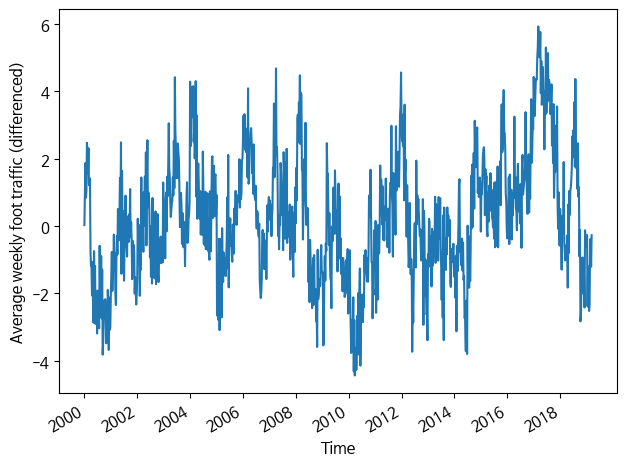

In [27]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

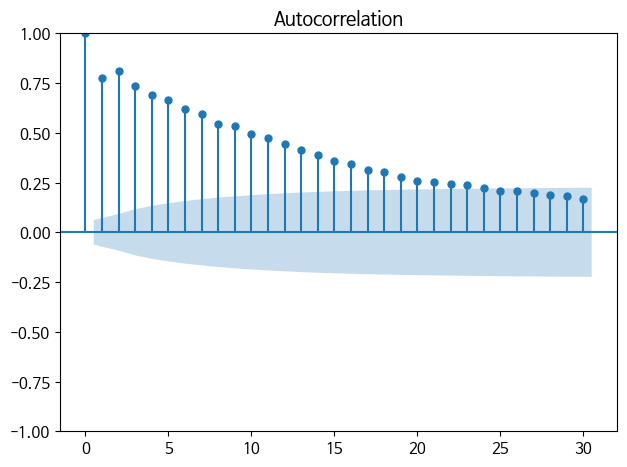

In [28]:
plot_acf(foot_traffic_diff, lags=30);

plt.tight_layout()
plt.show()

## 편자기상관함수 (PACF) - 가상 데이터
- 정상적 자기회귀과정의 차수 구하기
- ACF 도식으로는 차수에 대한 정보 얻을 수 없음
- PACF 함수 사용

In [29]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

- 해석 : 차수 2인 자기회귀과정으로 기반
  + 지연 2 이후에는 편자기상관계수가 0에서 큰 차이가 없음

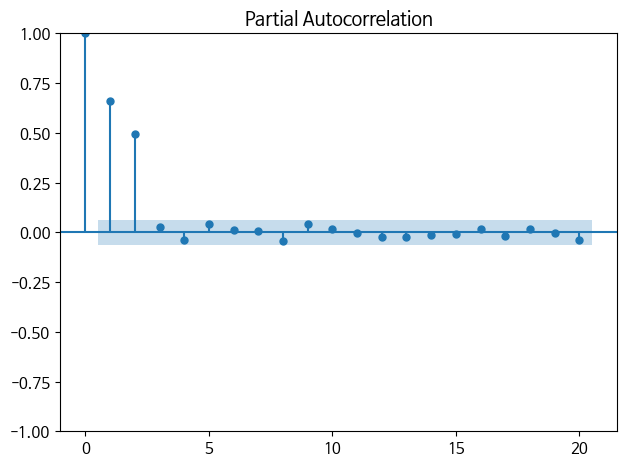

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);
plt.tight_layout()
plt.show()

## 편자기상관함수 (PACF) - 실제데이터
- 지연 3 이후에는 유의한 계수가 없음 확인, AR(3) 모형
- 차분된 주간 평균 유동 인구는 자수 3의 자기회귀과정

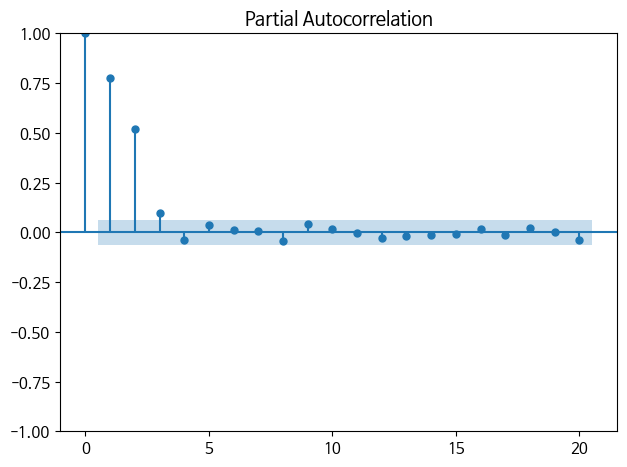

In [31]:
plot_pacf(foot_traffic_diff, lags=20);
plt.tight_layout()
plt.show()

## 자기회귀과정 예측
- 지난 52주간의 데이터, 테스트 집합에 저장
- 나머지는 훈련 집합에 저장

In [32]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

947
52


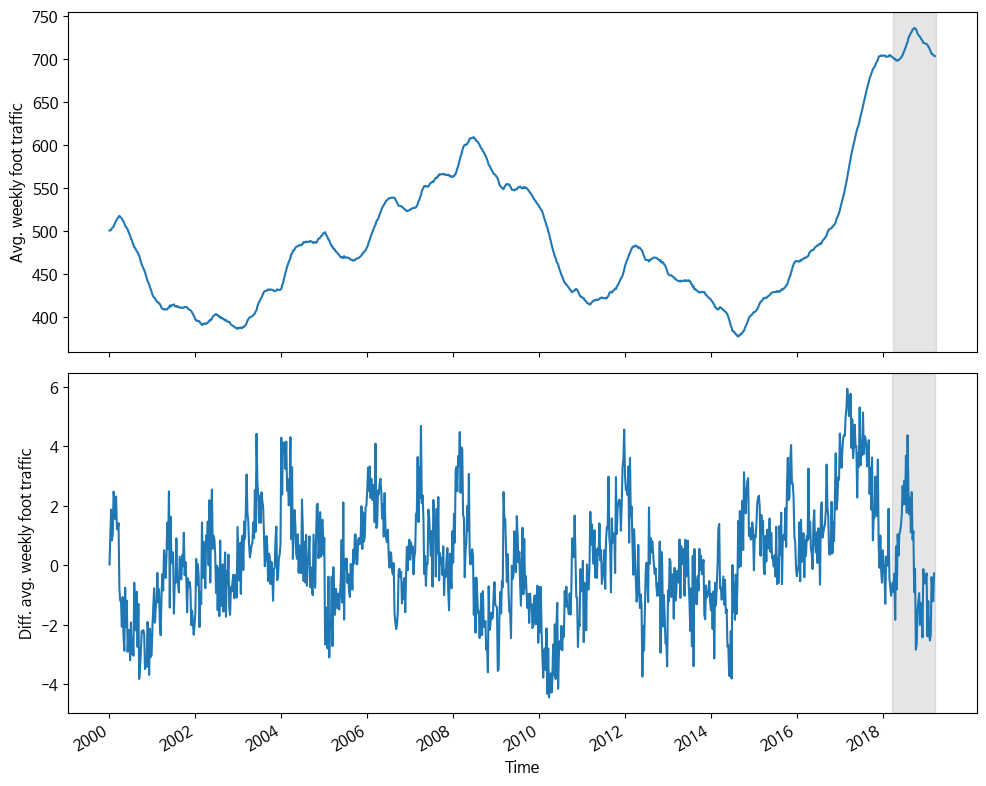

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

### 세가지 기법 사용
- 과거 평균
- 마지막으로 측정된 값 베이스라인
- AR(3) 모델

In [34]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [35]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


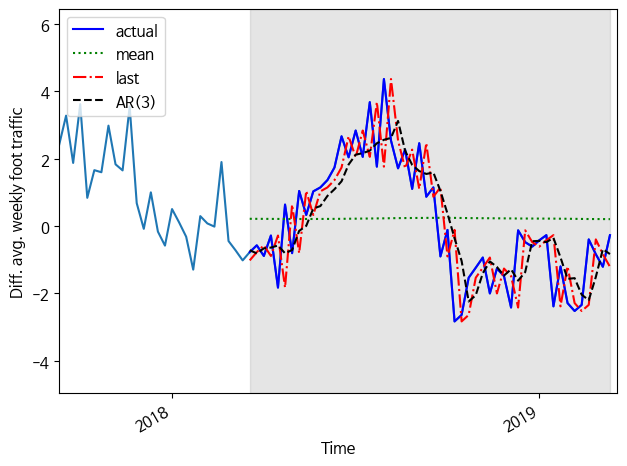

In [36]:
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모형 평가 비교

In [37]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164116852


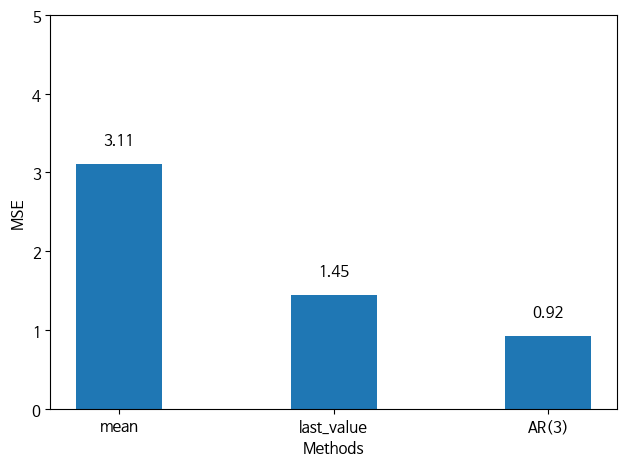

In [38]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.show()

## AR(3) 모델의 차분하지 않은 예측값

In [39]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

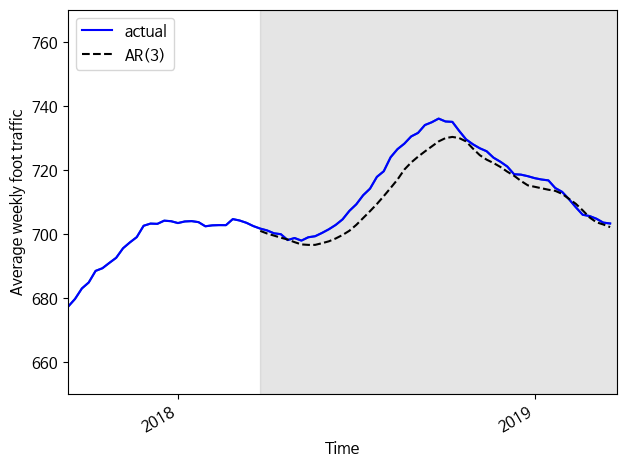

In [40]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

- 해석 : 한 주의 유동인구에 대한 예측이 실제값보다 평균적으로 3.45명 정도 높거나 낮게 차이 보임

In [41]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

3.478033559658852
